In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Dataset and Settings

In [2]:
MODIFIED_SGD = False
SAVE = True

In [3]:
DATASET = 'cifar10'
if DATASET     == 'cifar10':
    Ntr_samples= 50000
    mb_size    = 10         # mini-batch size (default : 10)
    n          = 10        # number of mini-batches in a large batch
    lb_size    = n*mb_size  # large batch size (after this gradient update with modified SGD rule)  
    n_lb       = int(Ntr_samples/(lb_size)) # number of large batches in a epoch
    epochs     = 100
    lr         = 0.1
    momentum   = 0.0    
    mean_imgs  = (0.5,0.5,0.5)
    std_imgs   = (0.5,0.5,0.5)
    imgs_shape = (3,32,32)

In [4]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
os.chdir(ROOT)

In [5]:
if MODIFIED_SGD:
    RES = os.path.join(ROOT,'results', DATASET, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)
else:
    RES = os.path.join(ROOT,'results', DATASET,'original', str(mb_size) + '_' + str(n)  )  
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET,'original', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)

Creating directory /home/ansuini/repos/WellTemperedSGD/results/cifar10/original/10_10
Creating directory /home/ansuini/repos/WellTemperedSGD/figures/cifar10/original/10_10


In [6]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from tqdm import tqdm
import pandas as pd
from wtsgd import *

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print('Device : {}'.format( device ) )

Device : cuda:0


In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean_imgs, std_imgs)])

trainset = torchvision.datasets.CIFAR10(ROOT +  '/data/' + DATASET, train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(ROOT +  '/data/' + DATASET, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=mb_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(train_loader.dataset)
print(test_loader.dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /home/ansuini/repos/WellTemperedSGD//data/cifar10
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: /home/ansuini/repos/WellTemperedSGD//data/cifar10
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


In [10]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 32, 32])


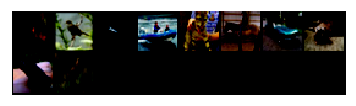

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

### Check labelling

Useful in case of random shuffling of labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


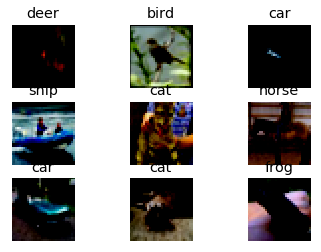

In [12]:
for i in range(9):
    plt.subplot(3,3,i+1)
    imshow(images[i,:])
    plt.title(classes[labels[i].item()])

In [13]:
def get_stats(loader):   
    '''
    Compute training statistics (loss and accuracy) on loader data
    '''
    loss = 0.0
    correct = 0
    total = 0       
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        l = loss.to('cpu').item()/total
        acc = 100 * correct/total
        return [l,acc]

# Initialize network, optimizer and loss

In [14]:
from cifar10_archs import Net
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [15]:
print(model)
print( summary(model, imgs_shape) )

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]            2416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]           48120
            Linear-6                   [-1, 84]           10164
            Linear-7                   [-1, 10]             850
Total params: tensor(62006)
T

In [16]:
train_stats = []
test_stats  = []
fractions   = []
params_stats= []
grad_stats  = []
grad2_stats = []
snr_stats   = []

for epoch in tqdm(range(epochs)):
    
    # init to zero accumulators for grad and grad2
    grad  = init_grad(model)
    grad2 = init_grad(model)  
    
    count = 0
    
    for i, data in enumerate(train_loader, 0):
                               
        # get the inputs and load it on device
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)  
       
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        loss.backward()
                
        # accumulate grad and grad2
        grad  = acc_grad(grad,model)
        grad2 = acc_grad2(grad2,model)
        
        if (i + 1) % n == 0 :
            
            count += 1
            #print('Epoch : {} mini-epoch/tot : {}/{}'.format(epoch, count, n_lb) )
            
            with torch.no_grad():
                
                # compute the snr 
                snr = compute_snr(grad, grad2, n)

                # temper the grad with the information on grad2
                fr = []
                grad_copy = []
                                              
                for p, g, s in zip(model.parameters(), grad, snr): 
                    grad_copy.append(p.grad.clone())
                    
                    # This is the only line where the true gradient is touched
                    # it substitute the gradient p.grad (that is the one computed on
                    # the last mini-batch, since optimizer.zero_grad() is always called)
                    # with the gradient accumulated in acc_grad. This gradient is averaged
                    # over the number of mini-batches in a large batch, so it is divided
                    # by n.
                    
                    # If we use the modified SGD, when the signal to noise 
                    # ratio is > 1 we leave grad untouched, otherwise the gradient is 
                    # multiplied by the signal to noise ratio value
                    
                    if MODIFIED_SGD:
                        p.grad = torch.where(s > 1, g/n, s * g/n)          
                    else:
                        p.grad = g/n
                        
                    fr.append(  ( s < 1).sum().item() / 
                             torch.prod(torch.tensor( s.size() ) ).item()  )       
            fractions.append(fr)        
    
            # store statistics about params grad, grad2 and snr    
            params_stats.append([ [x.mean().item(), x.std().item()]  for x in model.parameters() ] )
            grad_stats.append(  [ [x.mean().item(), x.std().item()]  for x in grad] )
            grad2_stats.append( [ [x.mean().item(), x.std().item()]  for x in grad2] )
            snr_stats.append(   [ [x.mean().item(), x.std().item()]  for x in snr] )
        
            # this is called after the large batch of n mini-batches
            optimizer.step()
            
            # set to zero accumulators for grad and grad2
            grad  = init_grad(model)
            grad2 = init_grad(model)
            
                          
    # save model
    if SAVE:
        #model.save_state_dict(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        torch.save(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        
    # get statistics
    train_stats.append(get_stats(train_loader))
    test_stats.append(get_stats(test_loader))
        
    # print statistics
    print('Train loss : %g --- Train acc : %g %%' % ( train_stats[-1][0], train_stats[-1][1] )) 
    print('Test  loss : %g --- Test  acc : %g %%' % ( test_stats[-1][0],  test_stats[-1][1] ))         

  1%|          | 1/100 [00:24<39:37, 24.02s/it]

Train loss : 0.176892 --- Train acc : 35.89 %
Test  loss : 0.177182 --- Test  acc : 35.83 %


  2%|▏         | 2/100 [00:47<38:30, 23.58s/it]

Train loss : 0.137147 --- Train acc : 50.432 %
Test  loss : 0.139026 --- Test  acc : 49.85 %


  3%|▎         | 3/100 [01:10<37:58, 23.49s/it]

Train loss : 0.125398 --- Train acc : 55.012 %
Test  loss : 0.130364 --- Test  acc : 53.71 %


  4%|▍         | 4/100 [01:34<37:42, 23.57s/it]

Train loss : 0.114035 --- Train acc : 59.304 %
Test  loss : 0.120946 --- Test  acc : 56.67 %


  5%|▌         | 5/100 [01:58<37:22, 23.60s/it]

Train loss : 0.107505 --- Train acc : 61.548 %
Test  loss : 0.117554 --- Test  acc : 57.86 %


  6%|▌         | 6/100 [02:21<36:54, 23.56s/it]

Train loss : 0.0999121 --- Train acc : 65.022 %
Test  loss : 0.112294 --- Test  acc : 60.3 %


  7%|▋         | 7/100 [02:46<36:46, 23.73s/it]

Train loss : 0.0944102 --- Train acc : 66.802 %
Test  loss : 0.110344 --- Test  acc : 60.93 %


  8%|▊         | 8/100 [03:09<36:21, 23.71s/it]

Train loss : 0.0934228 --- Train acc : 67.05 %
Test  loss : 0.112895 --- Test  acc : 60.54 %


  9%|▉         | 9/100 [03:34<36:08, 23.83s/it]

Train loss : 0.0862846 --- Train acc : 69.5 %
Test  loss : 0.108641 --- Test  acc : 61.91 %


 10%|█         | 10/100 [03:59<35:56, 23.96s/it]

Train loss : 0.0855295 --- Train acc : 69.394 %
Test  loss : 0.111304 --- Test  acc : 61.02 %


 11%|█         | 11/100 [04:24<35:36, 24.01s/it]

Train loss : 0.0782525 --- Train acc : 72.3 %
Test  loss : 0.108229 --- Test  acc : 62.57 %


 12%|█▏        | 12/100 [04:48<35:16, 24.05s/it]

Train loss : 0.0740363 --- Train acc : 74.24 %
Test  loss : 0.107487 --- Test  acc : 62.17 %


 13%|█▎        | 13/100 [05:13<34:57, 24.11s/it]

Train loss : 0.07333 --- Train acc : 73.99 %
Test  loss : 0.111161 --- Test  acc : 62.18 %


 14%|█▍        | 14/100 [05:37<34:31, 24.09s/it]

Train loss : 0.0677402 --- Train acc : 76.304 %
Test  loss : 0.11071 --- Test  acc : 62.75 %


 15%|█▌        | 15/100 [06:01<34:09, 24.12s/it]

Train loss : 0.0713914 --- Train acc : 74.69 %
Test  loss : 0.118071 --- Test  acc : 61.64 %


 16%|█▌        | 16/100 [06:26<33:50, 24.17s/it]

Train loss : 0.0654678 --- Train acc : 77.064 %
Test  loss : 0.113615 --- Test  acc : 62.35 %


 17%|█▋        | 17/100 [06:50<33:25, 24.17s/it]

Train loss : 0.0590356 --- Train acc : 79.128 %
Test  loss : 0.116549 --- Test  acc : 63.14 %


 18%|█▊        | 18/100 [07:15<33:01, 24.17s/it]

Train loss : 0.061121 --- Train acc : 78.166 %
Test  loss : 0.122473 --- Test  acc : 62.19 %


 19%|█▉        | 19/100 [07:39<32:40, 24.21s/it]

Train loss : 0.0552207 --- Train acc : 80.708 %
Test  loss : 0.119467 --- Test  acc : 62.17 %


 20%|██        | 20/100 [08:04<32:18, 24.23s/it]

Train loss : 0.0522519 --- Train acc : 81.754 %
Test  loss : 0.120996 --- Test  acc : 62.35 %


 21%|██        | 21/100 [08:29<31:56, 24.27s/it]

Train loss : 0.0515793 --- Train acc : 81.796 %
Test  loss : 0.124458 --- Test  acc : 61.39 %


 22%|██▏       | 22/100 [08:53<31:33, 24.27s/it]

Train loss : 0.0486348 --- Train acc : 82.63 %
Test  loss : 0.130472 --- Test  acc : 61.97 %


 23%|██▎       | 23/100 [09:19<31:12, 24.32s/it]

Train loss : 0.0475839 --- Train acc : 83.088 %
Test  loss : 0.134516 --- Test  acc : 61.53 %


 24%|██▍       | 24/100 [09:44<30:50, 24.34s/it]

Train loss : 0.0447052 --- Train acc : 84.32 %
Test  loss : 0.136584 --- Test  acc : 61.97 %


 25%|██▌       | 25/100 [10:08<30:26, 24.35s/it]

Train loss : 0.0430257 --- Train acc : 84.826 %
Test  loss : 0.135241 --- Test  acc : 61.61 %


 26%|██▌       | 26/100 [10:34<30:04, 24.39s/it]

Train loss : 0.0478832 --- Train acc : 82.626 %
Test  loss : 0.145712 --- Test  acc : 60.55 %


 27%|██▋       | 27/100 [10:57<29:38, 24.36s/it]

Train loss : 0.0427209 --- Train acc : 84.686 %
Test  loss : 0.147524 --- Test  acc : 61.85 %


 28%|██▊       | 28/100 [11:22<29:15, 24.38s/it]

Train loss : 0.0423232 --- Train acc : 84.766 %
Test  loss : 0.154831 --- Test  acc : 60.47 %


 29%|██▉       | 29/100 [11:46<28:50, 24.37s/it]

Train loss : 0.045961 --- Train acc : 83.334 %
Test  loss : 0.157823 --- Test  acc : 60.19 %


 30%|███       | 30/100 [12:11<28:26, 24.37s/it]

Train loss : 0.0364286 --- Train acc : 87.11 %
Test  loss : 0.158527 --- Test  acc : 60.49 %


 31%|███       | 31/100 [12:36<28:03, 24.39s/it]

Train loss : 0.0366387 --- Train acc : 86.898 %
Test  loss : 0.160991 --- Test  acc : 60.68 %


 32%|███▏      | 32/100 [13:00<27:38, 24.39s/it]

Train loss : 0.0419619 --- Train acc : 85.08 %
Test  loss : 0.172278 --- Test  acc : 59.94 %


 33%|███▎      | 33/100 [13:24<27:13, 24.38s/it]

Train loss : 0.034607 --- Train acc : 87.888 %
Test  loss : 0.164244 --- Test  acc : 59.72 %


 34%|███▍      | 34/100 [13:49<26:50, 24.40s/it]

Train loss : 0.0362903 --- Train acc : 87.094 %
Test  loss : 0.173804 --- Test  acc : 59.92 %


 35%|███▌      | 35/100 [14:14<26:26, 24.41s/it]

Train loss : 0.0397282 --- Train acc : 85.714 %
Test  loss : 0.171651 --- Test  acc : 58.99 %


 36%|███▌      | 36/100 [14:38<26:02, 24.42s/it]

Train loss : 0.0374409 --- Train acc : 86.734 %
Test  loss : 0.17394 --- Test  acc : 59.61 %


 37%|███▋      | 37/100 [15:03<25:38, 24.42s/it]

Train loss : 0.0326152 --- Train acc : 88.394 %
Test  loss : 0.175114 --- Test  acc : 60.27 %


 38%|███▊      | 38/100 [15:27<25:14, 24.42s/it]

Train loss : 0.0400771 --- Train acc : 85.49 %
Test  loss : 0.18369 --- Test  acc : 59.13 %


 39%|███▉      | 39/100 [15:52<24:49, 24.41s/it]

Train loss : 0.0304454 --- Train acc : 88.964 %
Test  loss : 0.189068 --- Test  acc : 59.54 %


 40%|████      | 40/100 [16:16<24:25, 24.42s/it]

Train loss : 0.0341924 --- Train acc : 87.65 %
Test  loss : 0.195986 --- Test  acc : 59.66 %


 41%|████      | 41/100 [16:41<24:00, 24.42s/it]

Train loss : 0.0306467 --- Train acc : 88.968 %
Test  loss : 0.192062 --- Test  acc : 59.93 %


 42%|████▏     | 42/100 [17:06<23:36, 24.43s/it]

Train loss : 0.0315664 --- Train acc : 88.544 %
Test  loss : 0.197336 --- Test  acc : 59.36 %


 43%|████▎     | 43/100 [17:29<23:11, 24.42s/it]

Train loss : 0.0318471 --- Train acc : 88.56 %
Test  loss : 0.204172 --- Test  acc : 59.01 %


 44%|████▍     | 44/100 [17:54<22:47, 24.43s/it]

Train loss : 0.029643 --- Train acc : 89.398 %
Test  loss : 0.203243 --- Test  acc : 59.16 %


 45%|████▌     | 45/100 [18:18<22:22, 24.41s/it]

Train loss : 0.0404855 --- Train acc : 85.768 %
Test  loss : 0.211716 --- Test  acc : 58.79 %


 46%|████▌     | 46/100 [18:43<21:59, 24.43s/it]

Train loss : 0.0267113 --- Train acc : 90.432 %
Test  loss : 0.202385 --- Test  acc : 59.66 %


 47%|████▋     | 47/100 [19:08<21:35, 24.44s/it]

Train loss : 0.0337375 --- Train acc : 87.88 %
Test  loss : 0.214532 --- Test  acc : 58.57 %


 48%|████▊     | 48/100 [19:32<21:09, 24.42s/it]

Train loss : 0.0362164 --- Train acc : 87.124 %
Test  loss : 0.226803 --- Test  acc : 57.8 %


 49%|████▉     | 49/100 [19:56<20:45, 24.43s/it]

Train loss : 0.028695 --- Train acc : 89.59 %
Test  loss : 0.214503 --- Test  acc : 59.43 %


 50%|█████     | 50/100 [20:21<20:21, 24.42s/it]

Train loss : 0.0283213 --- Train acc : 89.878 %
Test  loss : 0.215282 --- Test  acc : 58.75 %


 51%|█████     | 51/100 [20:47<19:58, 24.47s/it]

Train loss : 0.02825 --- Train acc : 89.964 %
Test  loss : 0.222763 --- Test  acc : 58.55 %


 52%|█████▏    | 52/100 [21:13<19:35, 24.49s/it]

Train loss : 0.0317901 --- Train acc : 88.416 %
Test  loss : 0.218568 --- Test  acc : 58.21 %


 53%|█████▎    | 53/100 [21:37<19:10, 24.48s/it]

Train loss : 0.0272597 --- Train acc : 90.288 %
Test  loss : 0.222484 --- Test  acc : 59.45 %


 54%|█████▍    | 54/100 [22:02<18:46, 24.50s/it]

Train loss : 0.0298759 --- Train acc : 89.26 %
Test  loss : 0.224496 --- Test  acc : 58.51 %


 55%|█████▌    | 55/100 [22:27<18:22, 24.49s/it]

Train loss : 0.0316701 --- Train acc : 88.716 %
Test  loss : 0.233839 --- Test  acc : 58.71 %


 56%|█████▌    | 56/100 [22:51<17:57, 24.49s/it]

Train loss : 0.0252281 --- Train acc : 91.006 %
Test  loss : 0.229317 --- Test  acc : 58.52 %


 57%|█████▋    | 57/100 [23:16<17:33, 24.50s/it]

Train loss : 0.0306126 --- Train acc : 89.232 %
Test  loss : 0.247271 --- Test  acc : 57.69 %


 58%|█████▊    | 58/100 [23:41<17:09, 24.50s/it]

Train loss : 0.0301875 --- Train acc : 89.18 %
Test  loss : 0.238147 --- Test  acc : 58.88 %


 59%|█████▉    | 59/100 [24:06<16:44, 24.51s/it]

Train loss : 0.0229813 --- Train acc : 91.804 %
Test  loss : 0.248236 --- Test  acc : 59.63 %


 60%|██████    | 60/100 [24:30<16:20, 24.50s/it]

Train loss : 0.0322034 --- Train acc : 88.65 %
Test  loss : 0.243154 --- Test  acc : 58.6 %


 61%|██████    | 61/100 [24:55<15:56, 24.51s/it]

Train loss : 0.0349784 --- Train acc : 87.806 %
Test  loss : 0.248648 --- Test  acc : 58.47 %


 62%|██████▏   | 62/100 [25:20<15:31, 24.52s/it]

Train loss : 0.0246445 --- Train acc : 91.294 %
Test  loss : 0.240682 --- Test  acc : 58.34 %


 63%|██████▎   | 63/100 [25:43<15:06, 24.51s/it]

Train loss : 0.0464634 --- Train acc : 84.678 %
Test  loss : 0.264482 --- Test  acc : 57 %


 64%|██████▍   | 64/100 [26:08<14:42, 24.51s/it]

Train loss : 0.0365827 --- Train acc : 87.588 %
Test  loss : 0.285619 --- Test  acc : 58.02 %


 65%|██████▌   | 65/100 [26:33<14:18, 24.52s/it]

Train loss : 0.0272879 --- Train acc : 90.196 %
Test  loss : 0.260007 --- Test  acc : 58.35 %


 66%|██████▌   | 66/100 [26:57<13:53, 24.51s/it]

Train loss : 0.0265133 --- Train acc : 90.522 %
Test  loss : 0.250199 --- Test  acc : 58.82 %


 67%|██████▋   | 67/100 [27:22<13:28, 24.51s/it]

Train loss : 0.0243863 --- Train acc : 91.202 %
Test  loss : 0.256016 --- Test  acc : 58.51 %


 68%|██████▊   | 68/100 [27:45<13:03, 24.50s/it]

Train loss : 0.0313307 --- Train acc : 89.06 %
Test  loss : 0.266066 --- Test  acc : 56.98 %


 69%|██████▉   | 69/100 [28:10<12:39, 24.50s/it]

Train loss : 0.0257917 --- Train acc : 90.868 %
Test  loss : 0.263432 --- Test  acc : 58.25 %


 70%|███████   | 70/100 [28:34<12:14, 24.50s/it]

Train loss : 0.027205 --- Train acc : 90.296 %
Test  loss : 0.280199 --- Test  acc : 58.16 %


 71%|███████   | 71/100 [28:58<11:50, 24.49s/it]

Train loss : 0.0325587 --- Train acc : 88.662 %
Test  loss : 0.282492 --- Test  acc : 58.06 %


 72%|███████▏  | 72/100 [29:22<11:25, 24.48s/it]

Train loss : 0.033481 --- Train acc : 88.526 %
Test  loss : 0.275828 --- Test  acc : 57.57 %


 73%|███████▎  | 73/100 [29:46<11:00, 24.47s/it]

Train loss : 0.0465704 --- Train acc : 84.932 %
Test  loss : 0.28867 --- Test  acc : 56.59 %


 74%|███████▍  | 74/100 [30:12<10:36, 24.49s/it]

Train loss : 0.0284916 --- Train acc : 89.954 %
Test  loss : 0.280584 --- Test  acc : 58.39 %


 75%|███████▌  | 75/100 [30:36<10:12, 24.49s/it]

Train loss : 0.0282642 --- Train acc : 90.152 %
Test  loss : 0.277405 --- Test  acc : 58.53 %


 76%|███████▌  | 76/100 [31:01<09:47, 24.49s/it]

Train loss : 0.0253627 --- Train acc : 91.176 %
Test  loss : 0.279673 --- Test  acc : 58.17 %


 77%|███████▋  | 77/100 [31:26<09:23, 24.49s/it]

Train loss : 0.0259726 --- Train acc : 90.674 %
Test  loss : 0.280764 --- Test  acc : 57.65 %


 78%|███████▊  | 78/100 [31:49<08:58, 24.49s/it]

Train loss : 0.0331155 --- Train acc : 88.736 %
Test  loss : 0.284547 --- Test  acc : 58.38 %


 79%|███████▉  | 79/100 [32:15<08:34, 24.49s/it]

Train loss : 0.031471 --- Train acc : 89.224 %
Test  loss : 0.285553 --- Test  acc : 57.7 %


 80%|████████  | 80/100 [32:39<08:09, 24.49s/it]

Train loss : 0.0267197 --- Train acc : 90.68 %
Test  loss : 0.29266 --- Test  acc : 57.95 %


 81%|████████  | 81/100 [33:04<07:45, 24.50s/it]

Train loss : 0.022623 --- Train acc : 91.99 %
Test  loss : 0.285618 --- Test  acc : 58.5 %


 82%|████████▏ | 82/100 [33:29<07:21, 24.51s/it]

Train loss : 0.0264814 --- Train acc : 90.638 %
Test  loss : 0.29043 --- Test  acc : 57.42 %


 83%|████████▎ | 83/100 [33:54<06:56, 24.52s/it]

Train loss : 0.0281643 --- Train acc : 90.234 %
Test  loss : 0.285913 --- Test  acc : 57.6 %


 84%|████████▍ | 84/100 [34:20<06:32, 24.52s/it]

Train loss : 0.0292215 --- Train acc : 90.014 %
Test  loss : 0.298757 --- Test  acc : 57.6 %


 85%|████████▌ | 85/100 [34:44<06:07, 24.53s/it]

Train loss : 0.0319347 --- Train acc : 89.226 %
Test  loss : 0.292029 --- Test  acc : 57.07 %


 86%|████████▌ | 86/100 [35:09<05:43, 24.53s/it]

Train loss : 0.0299379 --- Train acc : 89.718 %
Test  loss : 0.282667 --- Test  acc : 57.84 %


 87%|████████▋ | 87/100 [35:33<05:18, 24.52s/it]

Train loss : 0.025233 --- Train acc : 91.17 %
Test  loss : 0.293824 --- Test  acc : 57.28 %


 88%|████████▊ | 88/100 [35:58<04:54, 24.52s/it]

Train loss : 0.0351149 --- Train acc : 88.118 %
Test  loss : 0.3015 --- Test  acc : 57.05 %


 89%|████████▉ | 89/100 [36:22<04:29, 24.52s/it]

Train loss : 0.0243517 --- Train acc : 91.59 %
Test  loss : 0.307053 --- Test  acc : 58.01 %


 90%|█████████ | 90/100 [36:47<04:05, 24.53s/it]

Train loss : 0.0291313 --- Train acc : 90.28 %
Test  loss : 0.29615 --- Test  acc : 57.74 %


 91%|█████████ | 91/100 [37:12<03:40, 24.53s/it]

Train loss : 0.0365648 --- Train acc : 88.146 %
Test  loss : 0.310825 --- Test  acc : 56.98 %


 92%|█████████▏| 92/100 [37:37<03:16, 24.54s/it]

Train loss : 0.0329178 --- Train acc : 88.904 %
Test  loss : 0.302888 --- Test  acc : 56.99 %


 93%|█████████▎| 93/100 [38:02<02:51, 24.54s/it]

Train loss : 0.0298363 --- Train acc : 90.064 %
Test  loss : 0.320013 --- Test  acc : 57.76 %


 94%|█████████▍| 94/100 [38:27<02:27, 24.55s/it]

Train loss : 0.0373481 --- Train acc : 87.928 %
Test  loss : 0.312965 --- Test  acc : 56.84 %


 95%|█████████▌| 95/100 [38:52<02:02, 24.55s/it]

Train loss : 0.0242396 --- Train acc : 91.464 %
Test  loss : 0.304557 --- Test  acc : 57.87 %


 96%|█████████▌| 96/100 [39:17<01:38, 24.55s/it]

Train loss : 0.0211608 --- Train acc : 92.648 %
Test  loss : 0.313127 --- Test  acc : 58.48 %


 97%|█████████▋| 97/100 [39:42<01:13, 24.56s/it]

Train loss : 0.0192862 --- Train acc : 93.228 %
Test  loss : 0.312759 --- Test  acc : 57.86 %


 98%|█████████▊| 98/100 [40:06<00:49, 24.56s/it]

Train loss : 0.0253594 --- Train acc : 91.04 %
Test  loss : 0.309788 --- Test  acc : 57.54 %


 99%|█████████▉| 99/100 [40:31<00:24, 24.56s/it]

Train loss : 0.0321331 --- Train acc : 89.412 %
Test  loss : 0.328659 --- Test  acc : 57.15 %


100%|██████████| 100/100 [40:56<00:00, 24.56s/it]

Train loss : 0.0236975 --- Train acc : 91.928 %
Test  loss : 0.32083 --- Test  acc : 57.45 %


In [17]:
# save loss and accuracies in a dictionary
train_stats = np.asarray(train_stats)
test_stats  = np.asarray(test_stats)
fractions   = np.asarray(fractions)
params_stats= np.asarray(params_stats)
grad_stats  = np.asarray(grad_stats)
grad2_stats = np.asarray(grad2_stats)
snr_stats   = np.asarray(snr_stats)

tags = ['train_stats', 'test_stats', 'fractions', 'params_stats', 'grad_stats', 'grad2_stats', 'snr_stats' ]
vals = [train_stats, test_stats, fractions, params_stats, grad_stats, grad2_stats, snr_stats ]
training_data = dict(zip(tags, vals))
if SAVE:
    file = open( os.path.join( RES, 'training_data.pt') , 'wb' ) 
    pickle.dump(training_data,file)

In [18]:
win = 30
nchecks = int( np.floor(len(train_loader.dataset)/(mb_size*n) ))
layer_names = [m[0] for idx,m in enumerate(model.named_modules()) ]
layer_names.remove('')
layer_names.remove('pool')
print(layer_names)

['conv1', 'conv2', 'fc1', 'fc2', 'fc3']


In [19]:
def plot_results(figname, train_stats, test_stats, fractions, grad_stats, grad2_stats):

    fig = plt.figure(figsize=(20,20))
    plt.subplot(4,4,1)
    plt.plot(train_stats[:,0],'-',label='training loss')
    plt.plot(test_stats[:,0],'-',label='test loss')
    plt.xlabel('epoch')
    plt.title('loss')
    plt.legend()

    plt.subplot(4,4,2)
    plt.plot(train_stats[:,1],'-',label='training accuracy')
    plt.plot(test_stats[:,1],'-',label='test accuracy')
    plt.xlabel('epoch')
    plt.title('accuracy')
    plt.legend()

    plt.subplot(4,4,3)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean(fractions[:,i*2], win ),label=layer_names[i] ) 
    plt.legend()
    plt.xlabel('epoch')
    plt.title('fraction of $\eta < 1$')

    plt.subplot(4,4,4)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad_stats[:,i*2,0], win ),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad mean')

    plt.subplot(4,4,5)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad_stats[:,i*2,1], win ),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad std')

    plt.subplot(4,4,6)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad2_stats[:,i*2,0], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad2 mean')

    plt.subplot(4,4,7)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad2_stats[:,i*2,1], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad2 std')

    plt.subplot(4,4,8)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( snr_stats[:,i*2,0], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('snr mean')

    plt.subplot(4,4,9)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( snr_stats[:,i*2,1], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('snr std')

    plt.savefig(os.path.join(FIG, figname))
    
    plt.show()


/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:27: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:41: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:48: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykerne

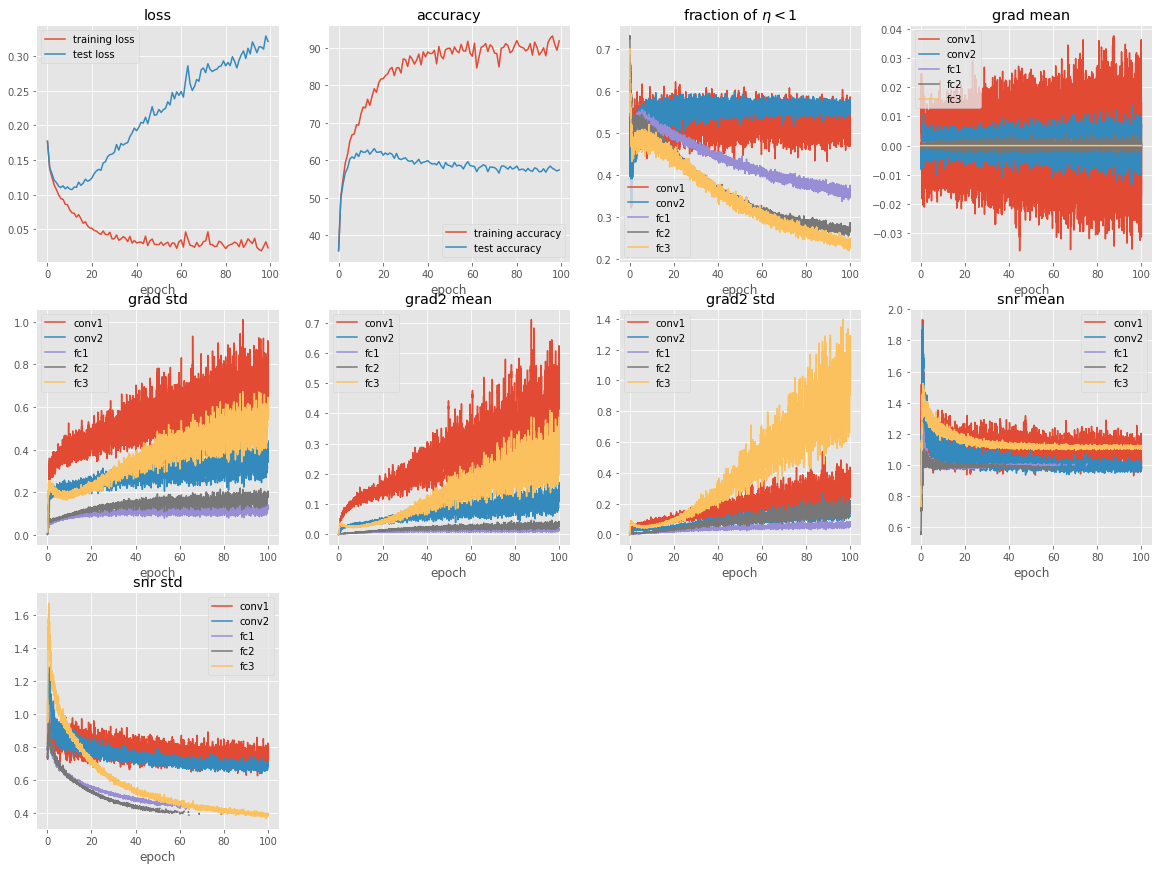

In [20]:
plot_results(DATASET, train_stats, test_stats, fractions, grad_stats, grad2_stats)